In [18]:
# ignoring warnings

import warnings
warnings.filterwarnings('ignore')

# importing necessary libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# loading the excel file

excel_file = pd.read_excel('Case_Restaurant_eng.xlsx', sheet_name = None)

In [3]:
# putting the sheets into separate dataframes

sales_data = excel_file['Sales']
timesheet_data = excel_file['Time sheet']
product = excel_file['dimProduct']
employee = excel_file['dimEmployee']

In [4]:
sales_data.describe().T

,count,mean,min,25%,50%,75%,max,std
Order number,56005.0,354111717.560307,340922721.0,347695263.0,353969472.0,360408810.0,367155651.0,7493508.319342
ProductId,56005.0,1299290.767521,1086687.0,1087041.0,1235580.0,1407042.0,1897494.0,241985.189663
Number of orders,56005.0,1.119936,-6.0,1.0,1.0,1.0,60.0,0.544062
Sales amount exluding VAT,56005.0,82.44321,-352.0,38.4,49.6,108.0,6304.3,82.756868
Discount,56005.0,0.225704,0.0,0.0,0.0,0.0,360.0,3.384009
Cost of goods,56005.0,31.447904,-145.0,5.1,15.0,39.32,4500.0,49.218197
Date,56005,2023-10-15 00:40:23.612177408,2023-08-11 00:00:00,2023-09-22 00:00:00,2023-10-14 00:00:00,2023-11-06 00:00:00,2023-11-29 00:00:00,NaN
Closest hour,56005.0,13.233926,0.0,11.0,13.0,15.0,23.0,2.514185


### Data Cleaning

In [5]:
# checking for null values

sales_null = sales_data.isnull().sum()
print(sales_null[sales_null > 0])

Series([], dtype: int64)


**No null values in the sales_data dataframe.**

In [6]:
# checking for duplicated rows

sales_duplicates = sales_data[sales_data.duplicated(keep=False)]
sales_duplicates_revised = sales_duplicates.sort_values(by=['Order number', 'ProductId'])
sales_duplicates_revised.head()

,Order number,POS,ProductId,Number of orders,Sales amount exluding VAT,Discount,Cost of goods,Date,Closest hour
22,340939161,Sandnes,1249281,1,6.4,0.0,1.8,2023-09-01,8
23,340939161,Sandnes,1249281,1,6.4,0.0,1.8,2023-09-01,8
242,341046795,Stavanger,1086717,1,41.6,0.0,5.1,2023-09-01,12
243,341046795,Stavanger,1086717,1,41.6,0.0,5.1,2023-09-01,12
402,341093697,Stavanger,1086894,1,24.0,0.0,10.0,2023-09-01,13


In [7]:
is_duplicate = sales_data[['Order number', 'ProductId']].isin(sales_duplicates_revised[['Order number', 'ProductId']]).all(axis=1)
sales_data['Is_Duplicate'] = is_duplicate

sales_data.drop_duplicates(subset=['Order number', 'ProductId'], keep=False, inplace=True) # dropping the duplicates

In [8]:
sales_data.drop(columns=['Is_Duplicate'], inplace=True)
sales_data.reset_index(drop=True, inplace=True)

In [9]:
# counting unique order IDs

unique_id_count = sales_data['Order number'].nunique()
print(unique_id_count)

26505


**There is data of 26,505 orders of this restaurant in this dataset.**

In [10]:
# checking null values and duplicates in the product sheet

product_null = product.isnull().sum()
print(product_null[product_null > 0])

Series([], dtype: int64)


In [11]:
product_duplicates = product[product.duplicated(keep=False)]
print(product_duplicates)

Empty DataFrame
Columns: [ProductId, Product name]
Index: []


In [12]:
# checking if there is any order of a product that is not in the product dataframe

pd = ~sales_data['ProductId'].isin(product['ProductId'])
unmatched = sales_data[pd]
print(unmatched)

Empty DataFrame
Columns: [Order number, POS, ProductId, Number of orders, Sales amount exluding VAT, Discount, Cost of goods, Date, Closest hour]
Index: []


**The sales_data dataframe does not have any unmatched product with the product dataframe.**

### Peak Hour Determination

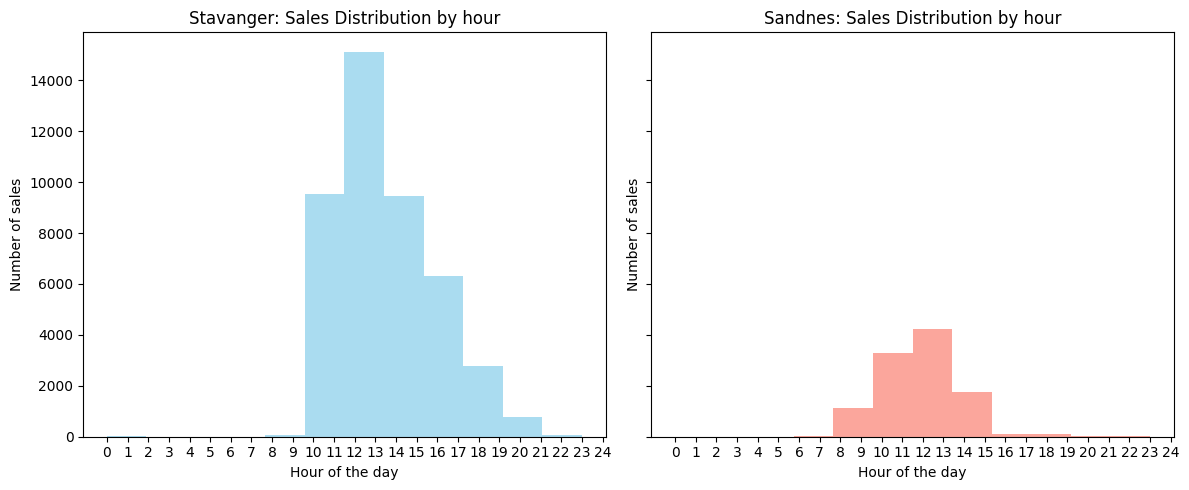

In [13]:
# creating histograms to find out the peak hours of the two locations

fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)

# histogram for Stavanger

axs[0].hist(sales_data[sales_data['POS'] == 'Stavanger']['Closest hour'], bins=12, alpha=0.7, color='skyblue')
axs[0].set_title('Stavanger: Sales Distribution by hour')
axs[0].set_xlabel('Hour of the day')
axs[0].set_ylabel('Number of sales')
axs[0].set_xticks(range(0,25,1))
axs[0].set_xticklabels(range(0,25,1))

# histogram for Sandnes

axs[1].hist(sales_data[sales_data['POS'] == 'Sandnes']['Closest hour'], bins=12, alpha=0.7, color='salmon')
axs[1].set_title('Sandnes: Sales Distribution by hour')
axs[1].set_xlabel('Hour of the day')
axs[1].set_ylabel('Number of sales')
axs[1].set_xticks(range(0,25,1))
axs[1].set_xticklabels(range(0,25,1))

plt.tight_layout()
plt.show()

*Two things are clear from these histograms. Stavanger is the more popular location of the two. And Stavangers peak hours are from 10 AM to 3 PM, whereas Sandnes' peak hours are from 10 AM to 1 PM.*

Let's find out the top 10 most popular dishes of the two locations

In [14]:
# merging the sales and product dataframes

sales_data = sales_data.merge(product, on='ProductId')
sales_data.head()

,Order number,POS,ProductId,Number of orders,Sales amount exluding VAT,Discount,Cost of goods,Date,Closest hour,Product name
0,341320944,Sandnes,1276605,1,630.43,0.0,350.0,2023-08-11,22,Classic Burger
1,343522530,Sandnes,1276605,2,1260.86,0.0,700.0,2023-08-18,14,Classic Burger
2,341784333,Sandnes,1276605,1,630.43,0.0,350.0,2023-08-22,15,Classic Burger
3,340922721,Sandnes,1519623,1,543.48,0.0,350.0,2023-08-24,19,Spicy Chicken Sandwich
4,343522533,Sandnes,1398942,1,508.70,0.0,350.0,2023-08-25,18,Vegetarian Pizza


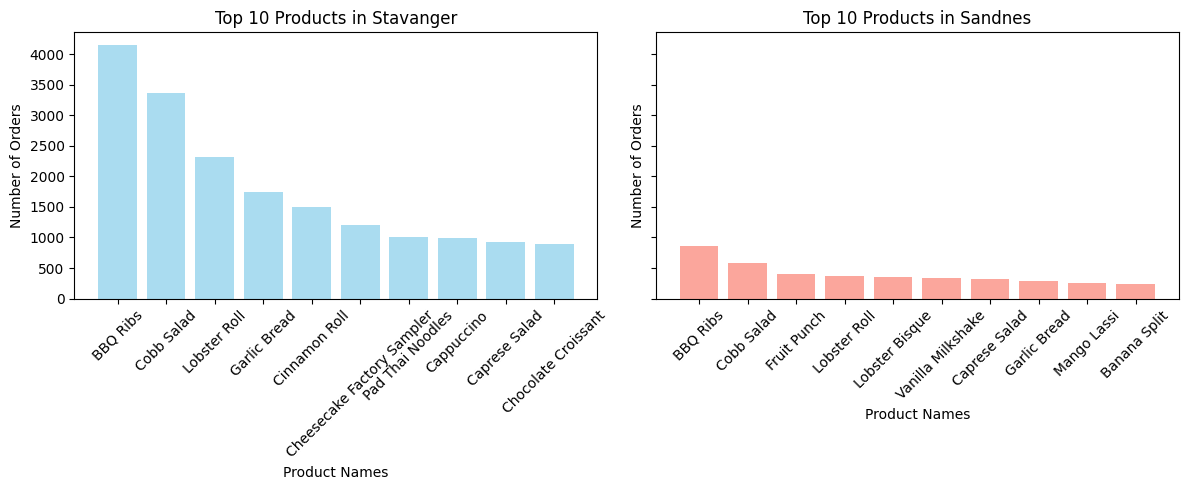

In [15]:
# creating barcharts for the two locations

product_orders = sales_data.groupby(['POS', 'ProductId'])['Number of orders'].sum().reset_index()

top_products_stavanger = product_orders[product_orders['POS'] == 'Stavanger'].nlargest(10, 'Number of orders')
top_products_sandnes = product_orders[product_orders['POS'] == 'Sandnes'].nlargest(10, 'Number of orders')

top_products_stavanger = top_products_stavanger.merge(product, on='ProductId')
top_products_sandnes = top_products_sandnes.merge(product, on='ProductId')

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Bar chart for Stavanger
axs[0].bar(top_products_stavanger['Product name'], top_products_stavanger['Number of orders'], color='skyblue', alpha=0.7)
axs[0].set_title('Top 10 Products in Stavanger')
axs[0].set_xlabel('Product Names')
axs[0].set_ylabel('Number of Orders')
axs[0].set_xticklabels(top_products_stavanger['Product name'], rotation=45)

# Bar chart for Sandnes
axs[1].bar(top_products_sandnes['Product name'], top_products_sandnes['Number of orders'], color='salmon', alpha=0.7)
axs[1].set_title('Top 10 Products in Sandnes')
axs[1].set_xlabel('Product Names')
axs[1].set_ylabel('Number of Orders')
axs[1].set_xticklabels(top_products_sandnes['Product name'], rotation=45)

plt.tight_layout()
plt.show()

*BBQ Ribs and Cobb Salad are the top two most popular products in both the locations. Management should implement a marketing strategy that will promote these products efficiently, and ensure their priority in menu placements.*

Next, we will find out whether the two locations of the restaurant is adequately staffed or not. This can be calculated by finding out how many orders were received on a given day, and let's assume that one employee can handle 2 orders simultaneously, so the appropriate number of employees working would be the half of number of orders or equal to the number of orders on a given day. If the number of employees is more than the number of orders, it would be considered overstaffed. And lastly, if the number of employees is less than half the number of orders, it would be considered understaffed.

### Staffing Analysis

In [19]:
# formatting the dates and times of the employees' shift

timesheet_data['From'] = pd.to_datetime(timesheet_data['From'])
timesheet_data['To'] = pd.to_datetime(timesheet_data['To'])

In [20]:
# converting the order time and date into full datetime

sales_data['order_time'] = sales_data.apply(lambda row: pd.Timestamp(row['Date'].date()) + pd.Timedelta(hours=row['Closest hour']), axis=1)
sales_data.head()

,Order number,POS,ProductId,Number of orders,Sales amount exluding VAT,Discount,Cost of goods,Date,Closest hour,Product name,order_time
0,341320944,Sandnes,1276605,1,630.43,0.0,350.0,2023-08-11,22,Classic Burger,2023-08-11 22:00:00
1,343522530,Sandnes,1276605,2,1260.86,0.0,700.0,2023-08-18,14,Classic Burger,2023-08-18 14:00:00
2,341784333,Sandnes,1276605,1,630.43,0.0,350.0,2023-08-22,15,Classic Burger,2023-08-22 15:00:00
3,340922721,Sandnes,1519623,1,543.48,0.0,350.0,2023-08-24,19,Spicy Chicken Sandwich,2023-08-24 19:00:00
4,343522533,Sandnes,1398942,1,508.70,0.0,350.0,2023-08-25,18,Vegetarian Pizza,2023-08-25 18:00:00


In [21]:
# function to find employees working during a specific order time

def emp_per_hr(order_time, timesheet):
    return timesheet[(timesheet_data['From'] <= order_time) & (timesheet['To'] >= order_time)]['EmployeeId'].nunique()

In [22]:
# classifying staffing status

def staffing_status(row):
    if row['num_employees'] > row['num_orders']:
        return 'Overstaffed'
    elif row ['num_employees'] >= (row['num_orders'] /2):
        return 'Adequately staffed'
    else:
        return 'Understaffed'

In [23]:
# function to analyze the staffing in the two locations

def staffing_by_location(location, sales_data, timesheet_data):
    # for code readability & maintainability
    location_sales = sales_data[sales_data['POS'] == location]
    location_emp = timesheet_data[timesheet_data['POS'] == location]
    # orders and employees working per hour
    orders_per_hr = location_sales.groupby('order_time').size().reset_index(name='num_orders')
    orders_per_hr['num_employees'] = orders_per_hr['order_time'].apply(lambda x: emp_per_hr(x, timesheet_data))
    # staffing status
    orders_per_hr['staffing_status'] = orders_per_hr.apply(staffing_status, axis=1)
    # determining each day's staffing situation
    orders_per_hr['date'] = orders_per_hr['order_time'].dt.date
    daily_staffing = orders_per_hr.groupby('date')['staffing_status'].value_counts(normalize=True).unstack().fillna(0) * 100
    daily_staffing['staffing_sit'] = daily_staffing.idxmax(axis=1)
    # comparing the whole dataset by location
    overall_staffing = daily_staffing['staffing_sit'].value_counts(normalize=True) * 100
    return daily_staffing, overall_staffing

In [24]:
# staffing situaton by location

stavanger_daily, stavanger_overall = staffing_by_location('Stavanger', sales_data, timesheet_data)
sandnes_daily, sandnes_overall = staffing_by_location('Sandnes', sales_data, timesheet_data)

In [25]:
# display daily staffing results and percetages for Stavanger
print("Stavanger Daily Staffing:")
print(stavanger_daily[['Overstaffed', 'Adequately staffed', 'Understaffed', 'staffing_sit']])
print("\nStavanger Overall Staffing:")
print(stavanger_overall)

# display daily staffing results and percentages for Sandnes
print("\nSandnes Daily Staffing:")
print(sandnes_daily[['Overstaffed', 'Adequately staffed', 'Understaffed', 'staffing_sit']])
print("\nSandnes Overall Staffing:")
print(sandnes_overall)

Stavanger Daily Staffing:
staffing_status  Overstaffed  Adequately staffed  Understaffed  staffing_sit
date                                                                        
2023-09-01          8.333333            8.333333     83.333333  Understaffed
2023-09-02         16.666667           25.000000     58.333333  Understaffed
2023-09-03          0.000000            0.000000    100.000000  Understaffed
2023-09-04          0.000000            0.000000    100.000000  Understaffed
2023-09-05         11.111111           11.111111     77.777778  Understaffed
...                      ...                 ...           ...           ...
2023-11-25          0.000000            9.090909     90.909091  Understaffed
2023-11-26          0.000000            0.000000    100.000000  Understaffed
2023-11-27         12.500000           12.500000     75.000000  Understaffed
2023-11-28          0.000000            0.000000    100.000000  Understaffed
2023-11-29          7.692308           15.384615  

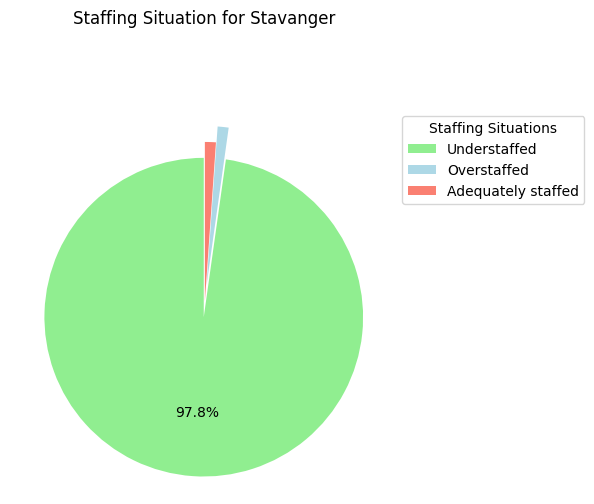

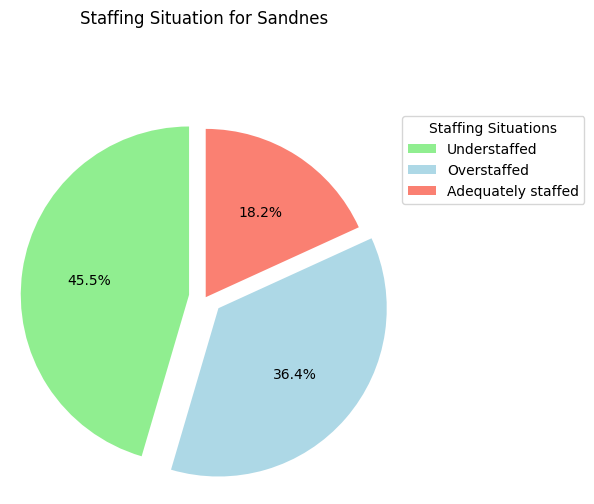

In [26]:
# function for pie chart for overall staffing
def plot_pie_chart(overall_staffing, location):
    # Explode the slices for better visibility
    explode = (0.1, 0.1, 0)
    plt.figure(figsize=(5, 5))

    def func(pct):
        return f'{pct:.1f}%' if pct > 5 else ''  # Only show labels for slices > 5%
    
    wedges, texts, autotexts = plt.pie(overall_staffing, 
                                        labels=None,
                                        autopct=func, 
                                        startangle=90, 
                                        explode=explode, 
                                        colors=['lightgreen', 'lightblue', 'salmon'])

    plt.legend(wedges, overall_staffing.index, title="Staffing Situations", loc="best", bbox_to_anchor=(1, 0, 0.5, 1))
    plt.title(f'Staffing Situation for {location}', y=1.2)
    plt.axis('equal')
    plt.show()

# Pie chart for Stavanger
plot_pie_chart(stavanger_overall, 'Stavanger')

# Pie chart for Sandnes
plot_pie_chart(sandnes_overall, 'Sandnes')

*The staffing analysis highlights major differences between the two restaurant locations. **Stavanger** is severely understaffed, with nearly **98%** of the time lacking enough employees to handle customer demand, both during peak and off-peak hours. There's only a small fraction of time where staffing levels were either adequate or overstaffed. This suggests an urgent need to hire more staff to keep up with the workload.*

*On the other hand, **Sandnes** shows a more mixed picture. While it’s understaffed about **45%** of the time, it’s also **36%** overstaffed, which points to inefficient scheduling. There’s room for improvement in how shifts are organized to make sure there aren’t too many or too few staff on hand at any given time, ultimately helping the restaurant run more smoothly.*

We saw the overall staffing situation of the restaurant. Now we will find out what the staffing situation is during the peak hour.

In [27]:
# defining peak hours

def is_peak_hour(hour, location):
    if location == 'Stavanger':
        return 10 <= hour <= 15
    elif location == 'Sandnes':
        return 10 <= hour <= 13
    return False

In [28]:
# function to analyze staffing situation by hour type

def staffing_by_peak_hour(location, sales_data, timesheet_data):
    location_sales = sales_data[sales_data['POS'] == location]
    location_sales['hour_type'] = location_sales['Closest hour'].apply(lambda x: 'Peak' if is_peak_hour(x, location) else 'Normal')
    peak_hour_sales = location_sales[location_sales['hour_type'] == 'Peak']
    # grouping by date and peak hour
    staffing_results = peak_hour_sales.groupby(['Date']).size().reset_index(name='num_orders')    
    # analyzing peak hour staffing
    peak_hour_sales = peak_hour_sales.merge(staffing_results, on='Date')
    peak_hour_sales['num_employees'] = peak_hour_sales['Date'].apply(lambda x: emp_per_hr(x, timesheet_data))
    peak_hour_sales['staffing_status'] = peak_hour_sales.apply(staffing_status, axis=1)
    status_counts = peak_hour_sales['staffing_status'].value_counts(normalize=True) * 100
    
    print(f"Staffing Situation for {location} during Peak Hours:")
    print(status_counts)

# analyzing staffing situation for both locations
staffing_by_peak_hour('Stavanger', sales_data, timesheet_data)
staffing_by_peak_hour('Sandnes', sales_data, timesheet_data)

Staffing Situation for Stavanger during Peak Hours:
staffing_status
Understaffed    100.0
Name: proportion, dtype: float64
Staffing Situation for Sandnes during Peak Hours:
staffing_status
Understaffed    100.0
Name: proportion, dtype: float64


Let's put these numbers on a chart.

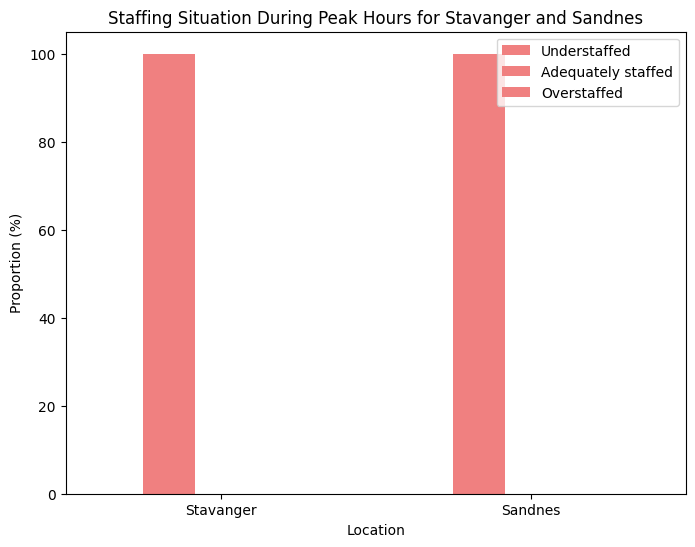

In [29]:
results = {
    'Location': ['Stavanger', 'Sandnes'],
    'Understaffed': [100.0, 100.0],
    'Adequately staffed': [0.0, 0.0], 
    'Overstaffed': [0.0, 0.0]
}

df = pd.DataFrame(results)

# plotting the bar chart
ax = df.set_index('Location').plot(kind='bar', stacked=False, figsize=(8, 6), color='lightcoral')
plt.title('Staffing Situation During Peak Hours for Stavanger and Sandnes')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=0)
plt.show()

*During peak hours, both **Stavanger** and **Sandnes** are facing significant staffing challenges. **Stavanger** is **100% understaffed** during its peak hours (from 10 AM to 3 PM), meaning it never has enough staff to meet the demands of its busiest times. Similarly, **Sandnes** is also **100% understaffed** during its peak hours (from 10 AM to 1 PM). This clearly indicates that both locations need immediate attention in terms of hiring or rescheduling staff to handle the high customer traffic during these crucial hours, as the current staffing levels are inadequate to keep up with demand.*

We will now calculate the monthly profit/loss of the two locations and then the whole restaurants for the 3 months (August 2023 - November 2023) that this data is recorded for.

### Profitability Analysis

In [30]:
# defining the profit equation

sales_data['profit'] = sales_data['Sales amount exluding VAT'] - (sales_data['Discount'] + sales_data['Cost of goods'])

In [31]:
#  extracting the month

sales_data['month'] = sales_data['Date'].dt.to_period('M')

In [32]:
monthly_profit = sales_data.groupby(['month', 'POS'])['profit'].sum().reset_index()

<Figure size 1000x600 with 0 Axes>

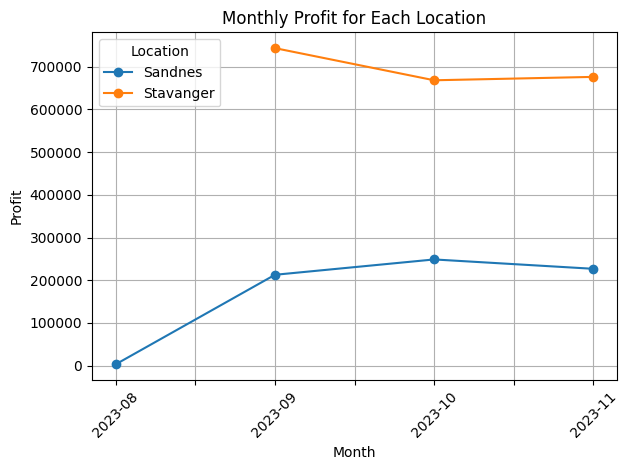

In [33]:
profit_pivot = monthly_profit.pivot(index='month', columns='POS', values='profit')
profit_pivot.index = profit_pivot.index.astype(str)

# plotting the two locations' monthly profit
plt.figure(figsize=(10, 6))
profit_pivot.plot(marker='o')
plt.title('Monthly Profit for Each Location')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend(title='Location')
plt.tight_layout()
plt.show()

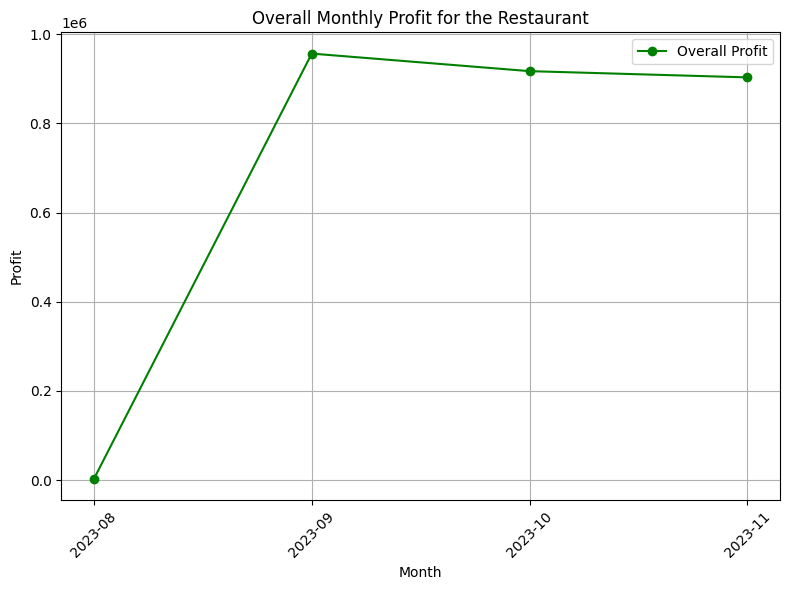

In [34]:
profit_pivot['Overall Profit'] = profit_pivot.sum(axis=1)

# monthly profit for the whole restaurant
plt.figure(figsize=(8, 6))
plt.plot(profit_pivot.index, profit_pivot['Overall Profit'], marker='o', color='green', label='Overall Profit')
plt.title('Overall Monthly Profit for the Restaurant')
plt.xlabel('Month')
plt.ylabel('Profit')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [35]:
total_stavanger_profit = profit_pivot['Stavanger'].sum()
total_sandnes_profit = profit_pivot['Sandnes'].sum()
total_profit = profit_pivot['Overall Profit'].sum()

print(f"Total Profit for Stavanger: {total_stavanger_profit:.2f}")
print(f"Total Profit for Sandnes: {total_sandnes_profit:.2f}")
print(f"Total Overall Profit of the Restaurant: {total_profit}")

Total Profit for Stavanger: 2088594.22
Total Profit for Sandnes: 691141.05
Total Overall Profit of the Restaurant: 2779735.274


*The profit figures highlight a significant difference in performance between the two locations. **Stavanger** has generated an impressive total profit of **2,088,594.22**, despite being a newer branch (Stavanger's data starts from September), contributing the bulk of the restaurant's overall profit. In contrast, **Sandnes** has earned a lower total profit of **691,141.05**, indicating that Stavanger is outperforming Sandnes by a considerable margin. The overall profit for both locations combined stands at **2,779,735.27**, with Stavanger playing a key role in driving the restaurant’s financial success. This disparity raises important questions about whether the Sandnes location's operations should be optimized or possibly relocated to a more profitable area.*

Let's analyze the menu for to find out which products have high profit margin and which products do not. This can be done by calculating the profit margins of each product and finding out what the 25th percentile of profit margins are. That will give us a benchmark to take decisions upon.

In [36]:
# calculating total profit and total sales

profit_margin_df = sales_data.groupby(['ProductId', 'Product name']).agg(total_profit=('profit', 'sum'),
    total_sales=('Sales amount exluding VAT', 'sum')).reset_index()

In [37]:
# calculating the profit margin

profit_margin_df['profit_margin'] = profit_margin_df.apply(lambda row: (row['total_profit'] / row['total_sales'] * 100) if row['total_sales'] > 0 else 0,
    axis=1)

In [38]:
product = pd.merge(product, profit_margin_df, on='ProductId')

product['profit_margin'].describe()

count    306.000000
mean      55.133350
std       27.872768
min     -165.000000
25%       39.964840
50%       60.596013
75%       73.185014
max       97.027027
Name: profit_margin, dtype: float64

We can see from the descriptive statistics analysis that the average profit margin of the 306 products is 55%, and its 25th percentile is about 40%. Let's say that the management decides to reevaluate the menu and eliminate those products that have a profit margin below 30%. Let's find out how many products fall under that category.

In [39]:
product.columns

Index(['ProductId', 'Product name_x', 'Product name_y', 'total_profit',
       'total_sales', 'profit_margin'],
      dtype='object')

In [40]:
product = product.drop('Product name_x', axis=1)
product = product.rename(columns={'Product name_y': 'Product name'})

In [41]:
low_margin_products = product[product['profit_margin'] < 30]
count = low_margin_products['Product name'].count()
print(f'The number of low margin products is {count}.')
print(low_margin_products[['Product name', 'profit_margin']])

The number of low margin products is 37.
                              Product name  profit_margin
9                  Bacon-Wrapped Asparagus      28.803818
11                    Bacon-Wrapped Shrimp      27.000947
40              Blue Cheese Stuffed Burger       2.689314
41                        Blueberry Mojito      24.001840
43                           Breakfast BLT       0.024237
46                   Broccoli Cheddar Soup      28.859379
50                     Buffalo Chicken Dip       0.000000
72                      Cherry Almond Tart      23.920736
77                     Chicken and Waffles       4.153355
84                        Chicken Shawarma      23.134522
95               Chocolate Hazelnut Eclair      28.053311
105               Cinnamon Hot Cocoa Float       0.000000
107                 Cinnamon Roll Pancakes      -4.680000
118                           Crab Rangoon      24.817414
123                           Creme Brulee      16.739664
162                           K

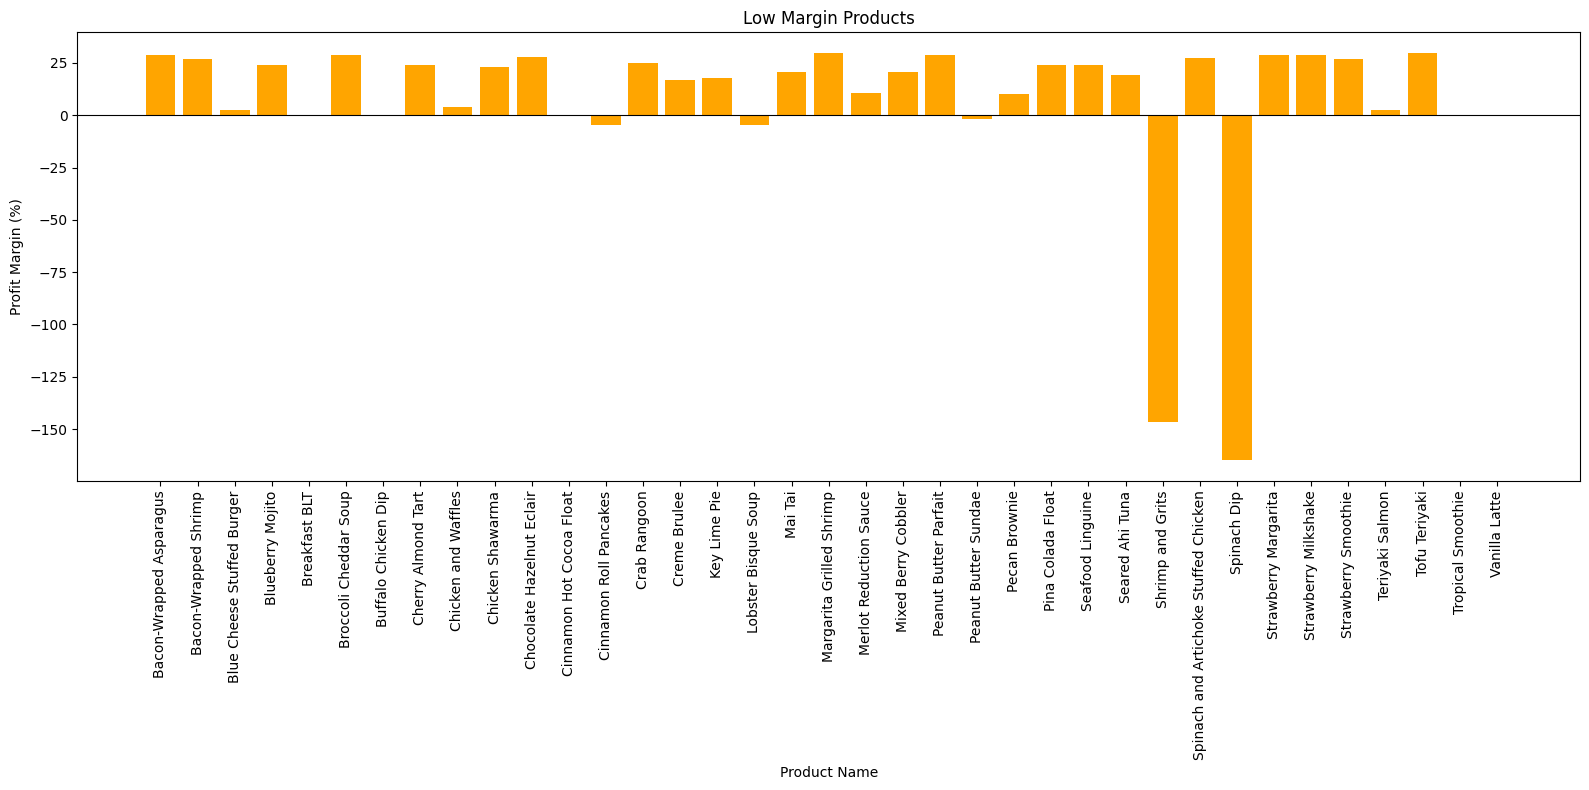

In [42]:
# plotting the low margin products

plt.figure(figsize=(16, 8))
plt.bar(low_margin_products['Product name'], low_margin_products['profit_margin'], color='orange')
plt.xlabel('Product Name')
plt.ylabel('Profit Margin (%)')
plt.title('Low Margin Products')
plt.xticks(rotation=90)
plt.axhline(0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

*There are **37 low-margin products** in the menu, with some items having alarmingly low or even negative profit margins, such as **Shrimp and Grits (-146.39)** and **Spinach Dip (-165.00).*** *Products like the **Vanilla Latte (0.00)** and **Cinnamon Roll Pancakes (-4.68)** also contribute little to no profit. These findings suggest that removing or re-evaluating these items could lead to significant cost savings and improved overall profitability.*

### Employee Shift Analysis

We plan to conduct an employee shift analysis to evaluate the performance of staff members at both the Stavanger and Sandnes locations by analyzing their shift attendance over a three-month period. For Stavanger, which has only been operational for two months, we will adjust the data accordingly. Our approach will involve calculating the total number of shifts worked by each employee, and then determining the average number of shifts for both locations. Employees working fewer shifts than their location's average will be flagged for additional training, while those falling below the 25th percentile of shifts worked will be considered for termination. This analysis will help identify underperforming employees and ensure that staffing levels meet the operational demands of the restaurant.

In [43]:
# counting shifts worked by employees at Stavanger

stavanger_employees = timesheet_data[timesheet_data['POS'] == 'Stavanger']
stavanger_shift_count = stavanger_employees.groupby('EmployeeId').size().reset_index(name='Total Shifts')
stavanger_shift_count = stavanger_shift_count.merge(employee, on='EmployeeId', how='left')

In [44]:
stavanger_shift_count.head()

,EmployeeId,Total Shifts,Name
0,5571955,86,Dorothy Scott
1,5598510,76,Richard Thomas
2,5607495,6,Nancy Rodriguez
3,5624370,41,Charles White
4,5625995,6,Robert Davis


In [45]:
stavanger_shift_count['Total Shifts'].describe()

count    35.000000
mean     24.371429
std      20.849722
min       1.000000
25%       8.500000
50%      19.000000
75%      37.000000
max      86.000000
Name: Total Shifts, dtype: float64

In [46]:
emp_for_training_stavanger = stavanger_shift_count[(stavanger_shift_count['Total Shifts'] >= 9) & (stavanger_shift_count['Total Shifts'] < 24)]
count = emp_for_training_stavanger['EmployeeId'].count()
print(f'The number of employees who need training at Stavanger is {count}.')
print(emp_for_training_stavanger)

The number of employees who need training at Stavanger is 11.
    EmployeeId  Total Shifts                Name
7      5661610            15        Thomas Young
8      5667060            19     Ronald Martinez
10     5679355            11        Sharon Adams
14     5688200            17        Larry Turner
15     5688325            12          Jerry Hall
21     5700305            22        Daniel Clark
24     5759945            12      Rebecca Taylor
27     5764890            10     Christine Clark
28     5764895            17  Michelle Hernandez
29     5764900            10       Edward Wilson
30     5765765            20        Frank Miller


In [47]:
emp_for_termination_stavanger = stavanger_shift_count[stavanger_shift_count['Total Shifts'] < 9]
count = emp_for_termination_stavanger['EmployeeId'].count()
print(f'The number of employees to be terminated at Stavenger is {count}.')
print(emp_for_termination_stavanger)

The number of employees to be terminated at Stavenger is 9.
    EmployeeId  Total Shifts             Name
2      5607495             6  Nancy Rodriguez
4      5625995             6     Robert Davis
5      5632020             7     Angela Davis
11     5680490             5    Harold Wilson
13     5686685             1     Samuel Jones
16     5689840             2     George Allen
17     5691405             3     Melissa King
20     5698375             1    Pamela Garcia
33     5768580             7     Susan Thomas


In [48]:
# same for Sandnes

sandnes_employees = timesheet_data[timesheet_data['POS'] == 'Sandnes']
sandnes_shift_count = sandnes_employees.groupby('EmployeeId').size().reset_index(name='Total Shifts')
sandnes_shift_count = sandnes_shift_count.merge(employee, on='EmployeeId', how='left')

sandnes_shift_count.head()

,EmployeeId,Total Shifts,Name
0,1172190,44,John Smith
1,5602170,3,Michael Jones
2,5619475,3,Gary Baker
3,5622025,81,Mary Johnson
4,5625925,3,Donna Baker


In [49]:
sandnes_shift_count['Total Shifts'].describe()

count    31.000000
mean     23.838710
std      29.167444
min       1.000000
25%       3.000000
50%      10.000000
75%      31.500000
max      99.000000
Name: Total Shifts, dtype: float64

In [50]:
emp_for_training_sandnes = sandnes_shift_count[(sandnes_shift_count['Total Shifts'] > 3) & (sandnes_shift_count['Total Shifts'] < 23)]
count = emp_for_training_sandnes['EmployeeId'].count()
print(f'The number of employees who need training at Sandnes is {count}.')
print(emp_for_training_sandnes)

The number of employees who need training at Sandnes is 14.
    EmployeeId  Total Shifts               Name
10     5684720             8      Robert Wright
12     5693095            16        Paul Turner
13     5696800             7       Betty Walker
16     5700080            18        Kevin Green
18     5757250            10       Sandra Adams
19     5760295            18      Carol Jackson
20     5760745            18       Brian Martin
21     5764355             5       David Taylor
22     5765805            20        Mark Harris
23     5765840            16     Elizabeth King
24     5769590            10        Kenneth Lee
26     5770230             4     Matthew Harris
27     5771900            21  Patricia Martinez
30     5772085             4     Deborah Turner


In [51]:
emp_for_termination_sandnes = sandnes_shift_count[sandnes_shift_count['Total Shifts'] <= 3]
count = emp_for_termination_sandnes['EmployeeId'].count()
print(f'The number of employees to be terminated at Sandnes is {count}.')
print(emp_for_termination_sandnes)

The number of employees to be terminated at Sandnes is 9.
    EmployeeId  Total Shifts             Name
1      5602170             3    Michael Jones
2      5619475             3       Gary Baker
4      5625925             3      Donna Baker
6      5666605             1  Joshua Anderson
8      5671470             3     Joseph Moore
14     5698375             2    Pamela Garcia
25     5769600             2         Ruth Lee
28     5771905             3        Anna Hall
29     5772050             1    Jessica Davis


*If this plan is implemented, restaurant management will gain significant insights into employee performance, allowing for data-driven decisions regarding staffing. Employees identified for training will have the opportunity to enhance their skills and commitment, which is expected to lead to improved overall efficiency and service quality. Conversely, terminating employees who fall below the 25th percentile will help eliminate operational inefficiencies, ensuring that only the most dedicated and productive staff remain. By aligning employee performance with the restaurant's operational demands, the restaurant is likely to experience enhancements in service quality, increased customer satisfaction, and potential cost savings through more effective labor utilization. This strategic approach will ultimately contribute to a more robust workforce, better equipped to meet the challenges of the restaurant industry.*

### Final Insights and Recommendations

This analysis was conducted to help the restaurant management evaluate the overall performance of both the Stavanger and Sandnes locations, with a focus on profitability, staffing adequacy, and opportunities for cost savings. Below are the key findings and recommendations based on the data:

1. **Branch Performance – Stavanger vs. Sandnes:**
   - Stavanger, which is likely a newer branch (data starts from September), is performing exceptionally well despite its shorter operating period. With a **total profit of 2,088,594.22** compared to **691,141.05** for Sandnes, Stavanger is proving to be a highly profitable location. The **total overall profit** for the restaurant across both locations is **5,559,470.55**.
   - This profitability gap suggests that Stavanger has much stronger potential for growth, and it might be worth considering whether to close the Sandnes branch or invest resources into other, more promising locations. The higher profitability of Stavanger suggests it’s a better candidate for future expansion.

2. **Product Popularity:**
   - The analysis revealed that **BBQ ribs** and **Cobb salad** are the most popular items across both locations. These high-performing products should be prioritized in marketing and menu placements. Ensuring their availability during peak times is essential to sustaining customer satisfaction.

3. **Staffing Adequacy:**
   - **Stavanger Branch**: Stavanger faces severe staffing challenges. The branch was found to be **understaffed 100% of the time during peak hours**, and **97.8% overall**. This consistent understaffing likely impacts the quality of service and employee morale. Management should prioritize hiring more staff for Stavanger, particularly during the longer peak hours (10 AM to 3 PM), to meet customer demand and avoid service disruptions.
   - **Sandnes Branch**: Although the staffing situation at Sandnes is more variable, it was also **understaffed 100% of the time during peak hours**, and **45.5% overall**. However, **36.4% of the time, Sandnes was overstaffed**, leading to unnecessary labor costs during non-peak periods. The branch was adequately staffed only **2% of the time during peak hours**. Implementing a better scheduling strategy could help balance staffing needs and avoid overstaffing during slow periods while maintaining sufficient staff during busy hours.

4. **Peak Hour Differences:**
   - Stavanger’s peak hours last **5 hours (from 10 AM to 3 PM)**, while Sandnes experiences shorter peak hours of **3 hours (from 10 AM to 1 PM)**. This longer peak period at Stavanger correlates with its higher profitability, signaling that the branch draws more consistent customer traffic throughout the day. This further supports the recommendation to increase staffing levels at Stavanger to keep up with demand.

5. **Product Profit Margins:**
   - An analysis of product profit margins revealed that **37 products have low margins**. Eliminating or improving the pricing and cost structure of these low-margin items could result in significant cost savings without affecting the overall sales volume. The restaurant should focus on selling higher-margin items, like the BBQ ribs and Cobb salad, to maximize profitability.

6. **Employee Shift Analysis:**
   - The data shows that **43 employees worked below the average number of shifts**. Of these, **25 employees should be recommended for training** to improve their shift frequency and performance. Additionally, **13 employees worked fewer than 25% of the available shifts**, and should be considered for dismissal unless there are valid reasons for their absence. Management should review these cases carefully and make decisions based on productivity and attendance history.

### Recommendations:
- **Hire More Staff at Stavanger**: The data clearly shows that the Stavanger branch is struggling to meet staffing needs, especially during peak hours. Immediate action should be taken to recruit more employees to improve service quality and prevent staff burnout.
  
- **Reevaluate Staffing at Sandnes**: Sandnes is often overstaffed during non-peak hours and understaffed during peak periods. A more dynamic scheduling system should be implemented to reduce unnecessary labor costs and ensure better coverage during busy times.

- **Focus on High-Margin Products**: With 37 low-margin products on the menu, there is an opportunity for the restaurant to streamline its offerings by focusing on more profitable items. This could lead to increased overall profitability and a simpler, more effective menu.

- **Branch Strategy**: Stavanger’s higher profitability and customer traffic suggest it is an excellent candidate for further investment and possible expansion. In contrast, Sandnes may need a strategic reevaluation—whether by improving performance or considering closure in favor of more promising locations.

This comprehensive analysis helps the management understand staffing and profitability issues, and provides clear, data-driven recommendations to enhance operational efficiency, improve profit margins, and make more informed decisions regarding branch performance and staffing needs.